# Data formats

Chemical compounds are usually stored in databases using the SMILES format. Usually CSV files are used for this purpose, where we have a `smiles` column, and other columns are molecular descriptors or experimental data. Sometimes we only get SMILES, in which case such files have the `.smi` extension, and molecules are saved as one SMILES string per line.

## Conformations and force fields

SMILES does not describe the spatial arrangement of atoms in the 3D space, which is called a **molecular conformation**. Conformations are produced by rotating single bonds in order to find an energetically stable pose. Multiple conformations are possible, as many conformations can be stable. We can employ computer tools to find conformations close to the real ones. We can use **force fields**, which are optimization methods that iteratively modify the conformation of a compound to minimize an energy function.

## 3D data formats for chemical compounds

If we need to store a compounds along with its conformation, the best widely used formats are MOL2 or SDF. These data formats enable storing information about atom positions, which is shown in the example below.

In [1]:
import os

import pandas as pd
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

from ipywidgets import interact

In [2]:
zinc_df = pd.read_csv('sample.smi', sep=' ')
zinc_df

,smiles,zinc_id
0,CC(=O)Nc1ccc(S(=O)(=O)N(C)CCO)cc1,29138
1,CCOc1ccc(C(=O)N[C@@H](C(=O)O)[C@H](C)O)cc1,344024
2,CNC(=O)N[C@@H]1N(C)C(=O)N[C@H](C(C)C)C1(C)C,517650
3,Cc1oc2nc(SCC(=O)NCCO)nc(N)c2c1C,2259245
4,O=C(O)CCCNC1=NS(=O)(=O)c2ccccc21,2637193
...,...,...
114001,O=C(c1nc[nH]c1C(F)(F)F)N1CCc2nn[nH]c2C1,828942673
114002,CNC(=O)CNC(=O)[C@H]1Cc2cc(Cl)ccc2O1,25266002
114003,CCOC1CC(CC(=O)N(C)[C@H]2C[C@@H](C(N)=O)C2)C1,863358233
114004,CNc1ccccc1C(=O)NC[C@@]1(O)CCO[C@@H]1C,227184162


In [3]:
def optimize_conformation(mol):
    mol = Chem.AddHs(mol)  # Adds hydrogens to make optimization more accurate
    AllChem.EmbedMolecule(mol)  # Adds 3D positions
    AllChem.MMFFOptimizeMolecule(mol)  # Improves the 3D positions using a force-field method
    return mol


@interact
def show_molecule(compound_idx=(0, len(zinc_df), 1)):
    smiles = zinc_df.iloc[compound_idx].smiles
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    mol = optimize_conformation(mol)
    mblock = Chem.MolToMolBlock(mol, kekulize=False)  # Produces a MOL block, which can be stored in a .mol file

    view = py3Dmol.view(width=800, height=500)
    view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
    view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    view.zoomTo({'model': -1})
    view.show()
    
    print('-' * 100)
    print(mblock)
    

interactive(children=(IntSlider(value=57003, description='compound_idx', max=114006), Output()), _dom_classes=…

# Proteins

Proteins are macromolecules (meaning they are big) that have various functions in the organism. Some proteins are involved in metabolism (mostly enzymes), other ones are involved in tranducing signals (G-protein-coupled receptors), and finally some take part in transporting ions (ion channels). Thus, proteins are the most popular target for small molecule drugs.

Proteins are **polymers**, which means they consist of smaller fragments called **amino acids**:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Amino_acids.png/924px-Amino_acids.png)

![](https://upload.wikimedia.org/wikipedia/commons/3/32/SIMPLIFIED_PEPTIDE_CHAIN.png)

Amino acids have different properties and influence the shape (conformation) of the molecule. Because proteins have a linear structure and consist of repeated amino acid blocks, we can store them as a sequence of letters corresponding to the consecutive amino acids, e.g. using the FASTA format. This is also called a **primary protein structure**.

```
>6NL3_1|Chain A|Cytochrome c oxidase assembly factor 6 homolog|Homo sapiens (9606)
GSMAAPSMKERQVCWGARDEYWKCLDENLEDASQCKKLRSSFESSCPQQWIKYFDKRRDYLKFKEKFEAGQFEPSETTAKS
```

## Protein folding


Protein conformations are a more complex problem than conformations of small molecules. The number of atoms and rotatable bonds in proteins is massive, so that the force-field calculation programs work poorly for proteins. Proteins in the organism are made sequentially and instantly undergo folding under well-defined physiological conditions, often with the help of other proteins, so-called chaperones. Therefore, the folding effect is very precise and deterministic despite the many points of freedom.

For a long time, the problem of protein folding was unattainable for computer methods, and until now the traditional method of discovering protein conformations is **crystallization**. The crystallized proteins can then be "photographed" to obtain a 3D model with high accuracy. Nowadays, computer methods are already achieving accuracy that until recently was thought to be impossible. DeepMind has developed the **AlphaFold** algorithm based on deep learning, which is able to predict 3D structures with an accuracy of 0.96 Å r.m.s.d.95 ( The next solution in the **CASP14** competition had a score of 2.8 Å r.m.s.d.95). DeepMind has started releasing prediction results for proteins whose crystals were previously unknown ([AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)). The AlphaFold implementation has been made open source, and predictions for new protein sequences can be made in-house using the provided [Colab notebook](https://colab.sandbox.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb).

![](https://lh3.googleusercontent.com/J5RC0j1DeUWaNc5h6nGwJwsQSLUuTXINP6we2ymLJ_WUg9bH-hvfvI8WVFeghN-_YR69MryNK5O2rFcVNwz9PZePpBtLdwdshCGzLdM=w2048-rw-v1)

## The PDB database

[PDB](https://www.rcsb.org/) is a database of protein structures, where we can find crystals of the biological targets that we are interested in. The most popular format of protein structures is in fact `.pdb`, a fragment of which is presented below ([CYP 3A4](https://www.rcsb.org/structure/6MA7)).

In [4]:
@interact
def show_protein(style=['balls & sticks', 'cartoon', 'surface']):
    view = py3Dmol.view(width=800, height=500, query='pdb:6MA7')
    if style == 'cartoon':
        view.setStyle({'model': -1}, {"cartoon": {'color': 'cyan'}})
    elif style == 'balls & sticks':
        view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    elif style == 'surface':
        view.setStyle({'model': -1}, {})
        view.addSurface('VDW')

    view.zoomTo({'model': -1})
    view.show()

interactive(children=(Dropdown(description='style', options=('balls & sticks', 'cartoon', 'surface'), value='b…

```
...
ATOM      1  N   GLY A  26     -34.317   8.706 -14.755  1.00128.59           N  
ANISOU    1  N   GLY A  26    16562  13800  18498   2794    437   1597       N  
ATOM      2  CA  GLY A  26     -33.904   7.326 -14.563  1.00126.57           C  
ANISOU    2  CA  GLY A  26    16140  13908  18043   2542    375   1417       C  
ATOM      3  C   GLY A  26     -32.608   6.995 -15.277  1.00128.93           C  
ANISOU    3  C   GLY A  26    16532  14226  18228   2319    463   1607       C  
ATOM      4  O   GLY A  26     -32.168   5.852 -15.299  1.00117.11           O  
ANISOU    4  O   GLY A  26    14921  13024  16553   2131    417   1500       O  
ATOM      5  N   THR A  27     -31.996   8.010 -15.878  1.00144.25           N  
ANISOU    5  N   THR A  27    18681  15832  20295   2349    618   1906       N  
ATOM      6  CA  THR A  27     -30.716   7.829 -16.548  1.00149.54           C  
ANISOU    6  CA  THR A  27    19431  16468  20918   2141    773   2119       C  
ATOM      7  C   THR A  27     -29.647   8.652 -15.842  1.00161.94           C  
ANISOU    7  C   THR A  27    21063  17579  22889   1854    953   2076       C  
ATOM      8  O   THR A  27     -29.018   9.523 -16.456  1.00167.94           O  
ANISOU    8  O   THR A  27    21978  18006  23825   1843   1158   2384       O  
ATOM      9  CB  THR A  27     -30.818   8.232 -18.017  1.00142.27           C  
ANISOU    9  CB  THR A  27    18706  15556  19794   2424    845   2558       C  
ATOM     10  OG1 THR A  27     -31.069   9.640 -18.105  1.00145.88           O  
ANISOU   10  OG1 THR A  27    19354  15572  20501   2606    963   2775       O  
ATOM     11  CG2 THR A  27     -31.950   7.475 -18.695  1.00132.20           C  
ANISOU   11  CG2 THR A  27    17362  14727  18142   2738    591   2545       C  
...
HETATM 3735  CHA HEM A 601     -15.300 -19.651  -9.279  1.00 42.50           C  
ANISOU 3735  CHA HEM A 601     4140   6322   5688     50   -273   -757       C  
HETATM 3736  CHB HEM A 601     -16.180 -22.481 -13.088  1.00 45.45           C  
ANISOU 3736  CHB HEM A 601     4576   6920   5771    211     98   -793       C  
HETATM 3737  CHC HEM A 601     -16.854 -26.224 -10.126  1.00 35.75           C  
ANISOU 3737  CHC HEM A 601     3757   5260   4565    363    -24   -922       C  
HETATM 3738  CHD HEM A 601     -15.649 -23.507  -6.308  1.00 43.62           C  
ANISOU 3738  CHD HEM A 601     4865   6249   5459    446   -422   -814       C  
HETATM 3739  C1A HEM A 601     -15.509 -20.056 -10.578  1.00 42.15           C  
ANISOU 3739  C1A HEM A 601     4058   6356   5602     54   -122   -714       C  
...
```

# Molecular docking

Molecular docking is a tool that facilitates the examination of interactions between a small molecule and its protein target. The surface of a protein has visible cavities (**binding pockets**) into which a molecule (also called a **ligand**) can enter to modulate the function of a given protein. Molecular docking tools aim to place the ligand in the most energetically favorable position in the protein's binding pocket. An energy function is defined, which is optimized by repositioning the ligand in the pocket and rotating the rotatable bonds. The conformation obtained by this process is called the **active conformation**.

Docking is also used in **virtual screening** to find molecules that bind well to a protein. This simulation suffers from considerable amount of error, but is very effective in filtering out molecules that bind poorly. A good docking score does not yet indicate the activity of the compound, but is an approximation of it.

**Exercise:** Dock molecules to the BACE crystal. Do docking scores correlate with compound activity?

In [15]:
bace_path = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/bace.csv'
df = pd.read_csv(bace_path)
# Due to limited computational power, I only used 300 samples from the dataset
test_df = df.sample(300)
print(test_df)

                                                    mol        CID  Class  \
1105  O=C(NC1CC1)c1ccc(cc1)-c1n(Cc2nc(N)ccc2)c(cc1)-...  BACE_1138      0   
1381  FC(F)(F)c1cc(ccc1)C1([NH+]=C(N2C1=NCCC2)N)c1cc...  BACE_1415      0   
1150  S1(=O)(=O)CC(Cc2ccccc2)C(O)C([NH2+]Cc2cc(ccc2)...  BACE_1183      0   
92    O1C[C@H](NC(=O)c2cc(cc(c2)[C@@H](O)[NH2+][C@H]...    BACE_93      1   
452   Fc1cc(cc(F)c1)CC(NC(=O)C)C(O)C[NH2+]C1(CCC(NO)...   BACE_482      1   
...                                                 ...        ...    ...   
1168  S(=O)(=O)(N(C)c1cc(cc(c1)C(=O)NC(C(O)CC(OC)COC...  BACE_1201      0   
1133     n1cc(ccc1)-c1cc(ccc1)C1(N=C(C)C(=N1)N)C1CCCCC1  BACE_1166      0   
112   O(C(=O)[C@H]1N(CCC1)C(=O)[C@H](N(C(=O)[C@@H](N...   BACE_114      0   
696   S1(=O)(=O)CC(Cc2cc(F)c(NC(=O)C[NH+](C)C)cc2)C(...   BACE_728      1   
1262  Clc1ccccc1-c1cc2c(Oc3c(cc(OC)cc3)C23N=C(OC3)N)cc1  BACE_1295      0   

      Model     pIC50         MW   AlogP  HBA  HBD  RB  ...  PEOE6 (PEOE6) 

In [16]:
def dock_molecule(mol, program='smina'):
    Chem.MolToMolFile(mol, f'molecule.mol')
    !obabel -imol molecule.mol -omol2 -O molecule.mol2
    os.remove(f'molecule.mol')
    
    # Dock the molecule stored in file molecule.mol2
    !{program} -r 4ivt.pdb -l molecule.mol2 --center_x 22.312222 --center_y 23.862839 --center_z 0.34194124 --size_x 30 --size_y 30 --size_z 30 --exhaustiveness 8 --cpu 1 --out molecule_docked.mol2

In [17]:
import tqdm
import re

docking_scores = []
for i, row in test_df.iterrows():
    smiles = row.mol
    mol = Chem.MolFromSmiles(smiles)
    optimize_conformation(mol)
    Chem.MolToMolFile(mol, f'molecule.mol', kekulize=False)
    !obabel -imol molecule.mol -omol2 -O molecule.mol2
    !smina -q -r 4ivt.pdb -l molecule.mol2 --center_x 22.312222 --center_y 23.862839 --center_z 0.34194124 --size_x 30 --size_y 30 --size_z 30 --exhaustiveness 3 --out molecule_docked.mol2
    output = !smina -r 4ivt.pdb -l molecule_docked.mol2 --score_only
    scores = re.findall(r'Affinity:\s*(\-?[\d\.]+)', '\n'.join(output))
    docking_score = float(scores[0])
    docking_scores.append(docking_score)
test_df['docking_score'] = docking_scores

1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.26398
Loop time 10.6354
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.49768
Loop time 7.22411
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 5.95995
Loop time 8.71317
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 12.9908
Loop time 15.0876
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|-

***************************************************
Refine time 16.0857
Loop time 19.6696
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 23.927
Loop time 28.0274
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 14.3564
Loop time 17.6826
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 9.72849
Loop time 13.9913
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.58428
Loop time 10.0676
1 molecule converted

0%   10   20 

***************************************************
Refine time 18.2517
Loop time 21.9126
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 4.68306
Loop time 9.64375
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 24.6387
Loop time 30.1011
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 23.1762
Loop time 28.4561
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.92027
Loop time 5.78578
1 molecule converted

0%   10   20

***************************************************
Refine time 27.9605
Loop time 31.6326
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 19.5608
Loop time 24.1026
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 1.07519
Loop time 3.26086
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 19.4544
Loop time 25.0829
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 11.9073
Loop time 15.4057
1 molecule converted

0%   10   20

***************************************************
Refine time 27.8891
Loop time 31.6447
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.45479
Loop time 5.55963
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 5.6487
Loop time 8.7125
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.88445
Loop time 8.49606
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 1.96947
Loop time 6.38566
1 molecule converted

0%   10   20  


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.43805
Loop time 11.9038
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 19.5245
Loop time 23.2725
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 8.89504
Loop time 13.7319
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 38.1554
Loop time 42.2284
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
****************

***************************************************
Refine time 16.4783
Loop time 19.5468
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.49753
Loop time 6.03395
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 4.76762
Loop time 6.75297
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 4.02914
Loop time 6.27238
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 10.0895
Loop time 12.6447
1 molecule converted

0%   10   20

***************************************************
Refine time 0.74201
Loop time 2.64613
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.74751
Loop time 5.67969
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 11.8587
Loop time 13.8746
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 25.2226
Loop time 28.5345
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 12.1232
Loop time 15.771
1 molecule converted

0%   10   20 


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.41682
Loop time 6.57539
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 38.6097
Loop time 42.3972
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.84738
Loop time 5.86896
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 144.931
Loop time 147.106
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
****************

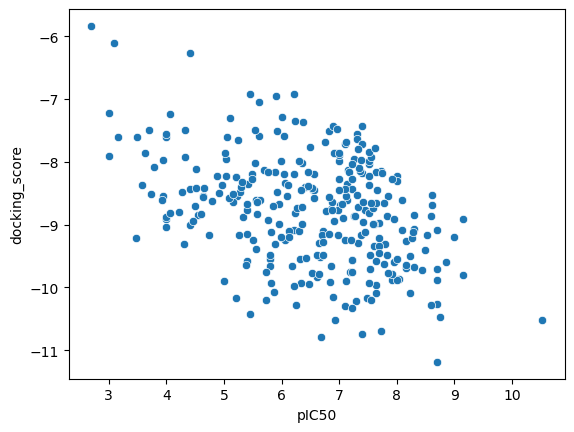

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=test_df, x='pIC50', y='docking_score')
plt.show()

widzimy niewielką korelację pomiędzy wynikiem dokowania a wartością pIC50.

### Molecular docking code

In [11]:
smiles = df.mol.iloc[0]
mol = Chem.MolFromSmiles(smiles)
optimize_conformation(mol)
dock_molecule(mol)

1 molecule converted
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -1889003310

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+

In [13]:
# Score only to see the scoring function components
import re

output = !smina -r 4ivt.pdb -l molecule_docked.mol2 --score_only
re.findall(r'Affinity:\s*(\-?[\d\.]+)', '\n'.join(output))

['   _______  _______ _________ _        _______ ', '  (  ____ \\(       )\\__   __/( (    /|(  ___  )', '  | (    \\/| () () |   ) (   |  \\  ( || (   ) |', '  | (_____ | || || |   | |   |   \\ | || (___) |', '  (_____  )| |(_)| |   | |   | (\\ \\) ||  ___  |', '        ) || |   | |   | |   | | \\   || (   ) |', '  /\\____) || )   ( |___) (___| )  \\  || )   ( |', '  \\_______)|/     \\|\\_______/|/    )_)|/     \\|', '', '', 'smina is based off AutoDock Vina. Please cite appropriately.', '', 'Weights      Terms', '-0.035579    gauss(o=0,_w=0.5,_c=8)', '-0.005156    gauss(o=3,_w=2,_c=8)', '0.840245     repulsion(o=0,_c=8)', '-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)', '-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)', '1.923        num_tors_div', '', '## Name gauss(o=0,_w=0.5,_c=8) gauss(o=3,_w=2,_c=8) repulsion(o=0,_c=8) hydrophobic(g=0.5,_b=1.5,_c=8) non_dir_h_bond(g=-0.7,_b=0,_c=8) num_tors_div', 'Affinity: -8.94326 (kcal/mol)', 'Intramolecular energy: -1.10737', 'Term values, befo

['-8.94326',
 '-8.82459',
 '-8.78291',
 '-8.75987',
 '-8.48743',
 '-8.62356',
 '-8.89611',
 '-8.54229',
 '-8.27492']

In [21]:
with open(f"4ivt.pdb") as ifile:
    system = "".join([x for x in ifile])

if os.path.exists(f"molecule_docked.mol2"):
    with open(f"molecule_docked.mol2") as ifile:
        mol = "".join([x for x in ifile])
        mols = ['@<TRIPOS>MOLECULE' + conf for conf in mol.split('@<TRIPOS>MOLECULE') if conf]
else:
    mols = None

view = py3Dmol.view(width=800, height=500)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'cyan'}})
if mols:
    view.addModel(mols[0], 'mol')
    view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
view.addBox({'center': {'x': 22.312222, 'y': 23.862839, 'z': 0.34194124}, 'dimensions': {'w': 30, 'h': 30, 'd': 30}, 'wireframe': True})
view.zoomTo({'model': -1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Detailed analysis of docked compounds

If we have our compounds docked, we can inspect interactions between the ligand and the protein. To that end, we can use the [ProLIF](https://prolif.readthedocs.io/en/latest/notebooks/visualisation.html) package. For example, we can use **interaction fingerprints** to train machine learning models. These fingerprints describe which ligand atoms interact with which amino acids, and what the types of interactions are.

Another important example of how we can use 3D shape of the docked compounds is to compute a **pharmacophore**, which is a set of 3D features that describe key interactions with the target. If we can find a set of interactions that are important for the ligand binding, we can propose a pharmacophoric hypothesis, which can be used to filter big databases of molecules in order to find so called **hits**.

In [22]:
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import numpy as np

fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [23]:
mol = Chem.MolFromMol2File('molecule_docked.mol2')

In [24]:
mol = Chem.AddHs(mol, addCoords=True)

view = py3Dmol.view(width=800, height=500)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'cyan'}})

view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
view.zoomTo({'model': -1})

feats = factory.GetFeaturesForMol(mol)
for feat in feats:
    atom_ids = feat.GetAtomIds()
    phtype = feat.GetType()
    if phtype == 'SingleAtomDonor':
        phcolor = 'blue'
    elif phtype == 'SingleAtomAcceptor':
        phcolor = 'red'
    elif phtype.startswith('Arom'):
        phcolor = 'green'
    else:
        continue
        print(phtype)
        phcolor = 'grey'
    pos = mol.GetConformer().GetPositions()[np.array(atom_ids)].mean(axis=0)
    view.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 
                    'radius': 1.5, 'color': phcolor, 'alpha': 1.0, 'wireframe': True});

view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
import prolif as plf
from rdkit import Chem

mol = Chem.MolFromPDBFile("4ivt.pdb", removeHs=False)
pmol = plf.Molecule(mol)

with open('molecule_docked.mol2', 'r') as file:
    mol_blocks = ['@<TRIPOS>MOLECULE'+block for block in file.read().split('@<TRIPOS>MOLECULE')][1:]
    mol = Chem.MolFromMol2Block(mol_blocks[0])
lmol = plf.Molecule.from_rdkit(mol)

In [26]:
fp = plf.Fingerprint()
fp.run_from_iterable([lmol], pmol)
df = fp.to_dataframe(return_atoms=True)
df.T

  0%|          | 0/1 [00:00<?, ?it/s]

Frame                               0
ligand protein  interaction          
UNL1   ASP228.A VdWContact    (9, 12)
       GLN73.A  VdWContact    (7, 15)
       GLY34.A  VdWContact     (4, 3)
       PRO70.A  Hydrophobic   (23, 5)
                VdWContact   (23, 10)
       THR231.A VdWContact    (26, 6)
       THR72.A  HBAcceptor    (14, 7)
                VdWContact    (14, 6)
       TYR198.A PiStacking     (0, 5)
       TYR71.A  Hydrophobic    (1, 6)
                VdWContact    (2, 16)

In [27]:
from rdkit import Chem
from rdkit import Geometry


def get_ring_centroid(mol, index):
    # find ring using the atom index
    Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
    ri = mol.GetRingInfo()
    for r in ri.AtomRings():
        if index in r:
            break
    else:
        raise ValueError(
            "No ring containing this atom index was found in the given molecule"
        )
    # get centroid
    coords = mol.xyz[list(r)]
    ctd = plf.utils.get_centroid(coords)
    return Geometry.Point3D(*ctd)

In [28]:
import py3Dmol

colors = {
    "Hydrophobic": "green",
    "HBAcceptor": "cyan",
    "HBDonor": "cyan",
    "XBDonor": "orange",
    "XBAcceptor": "orange",
    "Cationic": "red",
    "Anionic": "blue",
    "PiStacking": "purple",
}

# JavaScript functions
resid_hover = """function(atom,viewer) {{
    if(!atom.label) {{
        atom.label = viewer.addLabel('{0}:'+atom.atom+atom.serial,
            {{position: atom, backgroundColor: 'mintcream', fontColor:'black'}});
    }}
}}"""
hover_func = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.interaction,
            {position: atom, backgroundColor: 'black', fontColor:'white'});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

v = py3Dmol.view(650, 600)
v.removeAllModels()

models = {}
mid = -1
for i, row in df.T.iterrows():
    lresid, presid, interaction = i
    lindex, pindex = row[0]
    lres = lmol[lresid]
    pres = pmol[presid]
    # set model ids for reusing later
    for resid, res, style in [
        (lresid, lres, {"colorscheme": "cyanCarbon"}),
        (presid, pres, {}),
    ]:
        if resid not in models.keys():
            mid += 1
            v.addModel(Chem.MolToMolBlock(res), "sdf")
            model = v.getModel()
            model.setStyle({}, {"stick": style})
            # add residue label
            model.setHoverable({}, True, resid_hover.format(resid), unhover_func)
            models[resid] = mid
    # get coordinates for both points of the interaction
    if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "PiCation"]:
        p1 = get_ring_centroid(lres, lindex)
    else:
        p1 = lres.GetConformer().GetAtomPosition(lindex)
    if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "CationPi"]:
        p2 = get_ring_centroid(pres, pindex)
    else:
        p2 = pres.GetConformer().GetAtomPosition(pindex)
    # add interaction line
    v.addCylinder(
        {
            "start": dict(x=p1.x, y=p1.y, z=p1.z),
            "end": dict(x=p2.x, y=p2.y, z=p2.z),
            "color": colors.get(interaction, "grey"),
            "radius": 0.15,
            "dashed": True,
            "fromCap": 1,
            "toCap": 1,
        }
    )
    # add label when hovering the middle of the dashed line by adding a dummy atom
    c = Geometry.Point3D(*plf.utils.get_centroid([p1, p2]))
    modelID = models[lresid]
    model = v.getModel(modelID)
    model.addAtoms(
        [{"elem": "Z", "x": c.x, "y": c.y, "z": c.z, "interaction": interaction}]
    )
    model.setStyle({"interaction": interaction}, {"clicksphere": {"radius": 0.5}})
    model.setHoverable({"interaction": interaction}, True, hover_func, unhover_func)

# show protein
mol = Chem.RemoveAllHs(pmol)
pdb = Chem.MolToPDBBlock(mol, flavor=0x20 | 0x10)
v.addModel(pdb, "pdb")
model = v.getModel()
model.setStyle({}, {"cartoon": {"style": "edged"}})

v.zoomTo({"model": list(models.values())})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
from prolif.plotting.network import LigNetwork

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

## Docking-based deep learning

Deep learning can be used to improve molecular docking or boost molecular property prediction models. Examples are listed below.

Neural networks for molecular docking:

1. Lu, Wei, et al. "Tankbind: Trigonometry-aware neural networks for drug-protein binding structure prediction." bioRxiv (2022): 2022-06.
2. Stärk, Hannes, et al. "Equibind: Geometric deep learning for drug binding structure prediction." International Conference on Machine Learning. PMLR, 2022.
3. Corso, Gabriele, et al. "Diffdock: Diffusion steps, twists, and turns for molecular docking." arXiv preprint arXiv:2210.01776 (2022).

![](https://hannes-stark.com/assets/diffdock_example.gif)

Binding affinity prediction using neural networks:

1. McNutt, Andrew T., et al. "GNINA 1.0: molecular docking with deep learning." Journal of cheminformatics 13.1 (2021): 1-20.
2. Jones, Derek, et al. "Improved protein–ligand binding affinity prediction with structure-based deep fusion inference." Journal of chemical information and modeling 61.4 (2021): 1583-1592.